In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

RANDOM_SEED=42

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Download Dataset

In [2]:
iris = load_iris()
X = iris['data']
y = iris['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1./3, random_state=RANDOM_SEED)

# Normalization

In [3]:
train_mean = np.mean(X_train)
train_std = np.std(X_train)

X_train_normalized = torch.from_numpy((X_train - train_mean) / train_std).float()
X_test_normalized = torch.from_numpy((X_test - train_mean) / train_std).float()

y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

# Datasets & Data Loaders

In [4]:
train_ds = TensorDataset(X_train_normalized, y_train)
train_dl = DataLoader(train_ds, batch_size=2, shuffle=True)

# Model Definition

In [5]:
class Model(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)
    
    
    def forward(self, x):
        x = self.layer1(x)
        x = torch.sigmoid(x)
        
        x = self.layer2(x)
        x = torch.softmax(x, dim=1)
        
        return x

In [6]:
model = Model(input_size=X_train_normalized.shape[1], hidden_size=16, output_size=3)

In [7]:
writer = SummaryWriter(log_dir="runs/iris6")

In [8]:
writer.add_graph(model, input_to_model=torch.rand(2, 4))
writer.flush()

# Training Loop

In [9]:
def train(model: nn.Module, 
          optimizer: torch.optim.Optimizer, 
          loss_fn, 
          train_dl: DataLoader,
          num_epochs: int
    ) -> tuple:
    
    model.train()
    
    epochs_loss_history = []
    epochs_train_accuracy_history = []
    labels = []
    preds = []
    
    for epoch_index in range(num_epochs):
        
        epoch_loss_history = []
        epoch_train_accuracy_history = []
        
        for x_batch, y_batch in train_dl:
            predictions = model(x_batch)
            
            loss = loss_fn(predictions, y_batch)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            epoch_loss_history.append(loss.item())
            
            correct_predictions = (torch.argmax(predictions, axis=1) == y_batch).int()
            batch_correct_predictions_count = correct_predictions.sum().item()
            train_batch_accuracy = batch_correct_predictions_count / x_batch.shape[0]
            epoch_train_accuracy_history.append(train_batch_accuracy)
            
        
        epochs_loss_history.append(np.array(epoch_loss_history).mean())
        epochs_train_accuracy_history.append(np.array(epoch_train_accuracy_history).mean())
        
        writer.add_scalar('train_loss', epochs_loss_history[epoch_index], epoch_index)
        writer.add_scalar('train_acc', epochs_train_accuracy_history[epoch_index], epoch_index)
        
        print(f"Epoch {epoch_index + 1}/{num_epochs} | train_loss: {epochs_loss_history[epoch_index]:.4f} | train_acc: {epochs_train_accuracy_history[epoch_index]*100:.2f}%")
    
    writer.close()
    return epochs_loss_history, epochs_train_accuracy_history

# Train Model

In [10]:
lr=0.01
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=lr)
num_epochs=100

epochs_loss_history, epochs_train_accuracy_history = train(model, optimizer, loss_fn, train_dl, num_epochs)

Epoch 1/100 | train_loss: 1.0761 | train_acc: 42.00%
Epoch 2/100 | train_loss: 0.9370 | train_acc: 65.00%
Epoch 3/100 | train_loss: 0.8329 | train_acc: 74.00%
Epoch 4/100 | train_loss: 0.7785 | train_acc: 92.00%
Epoch 5/100 | train_loss: 0.7337 | train_acc: 90.00%
Epoch 6/100 | train_loss: 0.7039 | train_acc: 92.00%
Epoch 7/100 | train_loss: 0.6818 | train_acc: 92.00%
Epoch 8/100 | train_loss: 0.6650 | train_acc: 93.00%
Epoch 9/100 | train_loss: 0.6651 | train_acc: 90.00%
Epoch 10/100 | train_loss: 0.6470 | train_acc: 94.00%
Epoch 11/100 | train_loss: 0.6441 | train_acc: 92.00%
Epoch 12/100 | train_loss: 0.6345 | train_acc: 94.00%
Epoch 13/100 | train_loss: 0.6300 | train_acc: 95.00%
Epoch 14/100 | train_loss: 0.6297 | train_acc: 95.00%
Epoch 15/100 | train_loss: 0.6224 | train_acc: 95.00%
Epoch 16/100 | train_loss: 0.6245 | train_acc: 93.00%
Epoch 17/100 | train_loss: 0.6166 | train_acc: 95.00%
Epoch 18/100 | train_loss: 0.6168 | train_acc: 95.00%
Epoch 19/100 | train_loss: 0.6149 | t

# Evaluate Neural Network Performance

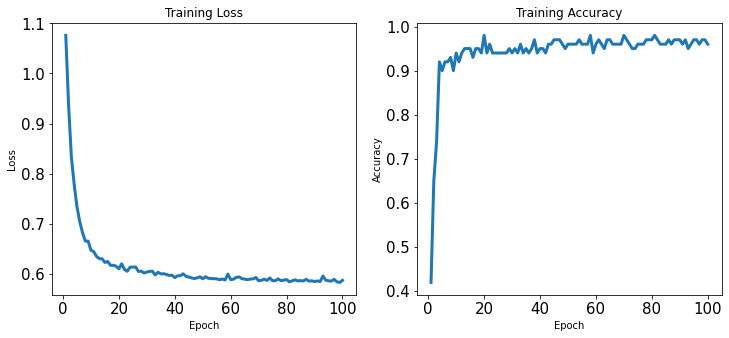

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
ax = axes.flatten()

epochs = np.arange(1, num_epochs + 1, 1)

ax[0].plot(epochs, epochs_loss_history, lw=3)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].tick_params(axis='both', which='major', labelsize=15)

ax[1].plot(epochs, epochs_train_accuracy_history, lw=3)
ax[1].set_title('Training Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].tick_params(axis='both', which='major', labelsize=15)

# Test Set Performance Evaluation

In [12]:
def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]
    classes = ['Iris Setosa', 'Iris Versicolour', 'Iris Virginica']
    writer.add_pr_curve(classes[class_index],
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)
    writer.flush()

In [13]:
pred_test = model(X_test_normalized)

correct_predictions = (torch.argmax(pred_test, dim=1) == y_test).float()
test_accuracy = correct_predictions.mean()

for class_index in range(3):
    add_pr_curve_tensorboard(class_index, pred_test, y_test)


print(f"Test acc: {test_accuracy*100:.2f}%")

Test acc: 98.00%


# Saving Model Weights

In [132]:
torch.save(model.state_dict(), 'model_weights.pt')